<a href="https://colab.research.google.com/github/Anjan-AI/TSAI-EVA5/blob/master/Session%2012%20-%20Object%20Localization%20YOLO%20(%20Part%201)/EVA5_Session_12_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%rm -rf TSAI-EVA5/

In [ ]:
!git clone https://github.com/Anjan-AI/TSAI-EVA5.git

Cloning into 'TSAI-EVA5'...
remote: Enumerating objects: 324, done.
remote: Counting objects: 100% (324/324), done.
remote: Compressing objects: 100% (260/260), done.
remote: Total 931 (delta 135), reused 234 (delta 56), pack-reused 607
Receiving objects: 100% (931/931), 47.63 MiB | 18.93 MiB/s, done.
Resolving deltas: 100% (390/390), done.


In [1]:
import sys
sys.path.append('/content/TSAI-EVA5/Session 12 - Object Localization YOLO ( Part 1)/')

In [2]:
import torch
import os
import torchvision
import torchvision.transforms as transfroms
from Dataset.dataset import Dataset,cifar10_classes
from Dataset.dataset import GetTinyImageNet ## new
#from Dataset.image_augmentations import AlbumentationTransforms
from Dataset.image_aug import AlbumentationTransforms
from Utils.SetCuda import set_seed,initialize_cuda
from Utils.utilities import print_model_summary,cross_entropy_loss
from Utils.evaluate import show_misclassified_images,evaluate_classwise_accuracy
from Utils.GradCam import GradCamView
from Utils.show_image import imshow ,show_train_data,show_train_data_imagenet
from models.resnet import ResNet18
#from models.S11_model import NewResnet
from Training.Training_Testing import train ,test,runmodel

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from Utils.lr_finder import LRFinder

import albumentations as A

In [3]:
channel_means = (0.442,0.442,0.442)
channel_stdevs = (0.278, 0.278, 0.278)
train_transform = AlbumentationTransforms([
                                       A.PadIfNeeded(min_height=72, min_width=72, p=1.0),
                                       A.RandomCrop(height=64, width=64, p=1.0),
                                       A.Rotate((-10.0, 10.0)),
                                       A.HorizontalFlip(p = 0.7),
                                       A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.5),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       A.Cutout(num_holes=1, max_h_size=32,max_w_size = 32,p=1) 
                                       ])
test_transform = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])

In [4]:
Data = GetTinyImageNet(train_transform, test_transform, split=0.7)

train_set = Data.get_dataset(train = True)
test_set = Data.get_dataset(train = False)
classes = Data.classes

len(train_set), len(test_set), len(classes)

TinyImageNet Downloaded
Found 200 classes


(77000, 33000, 200)

In [5]:
seed =1
cuda,device = initialize_cuda(seed)

GPU Available? True


In [6]:
train_loader = Data.data_loader(train_set,cuda= cuda ,batch_size = 256 , num_workers = 8 )
test_loader = Data.data_loader(test_set,cuda= cuda ,batch_size = 256 , num_workers = 8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


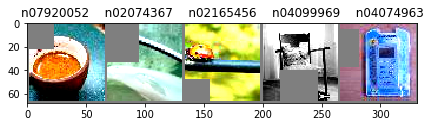

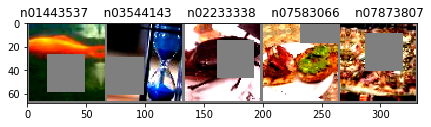

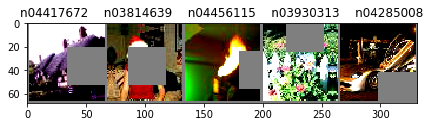

In [7]:
show_train_data_imagenet(train_loader, classes,3)

In [8]:
model = ResNet18(num_classes=200)
type(model)
print_model_summary(model, input_size = (3,64,64), device=device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1,

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.48E-02


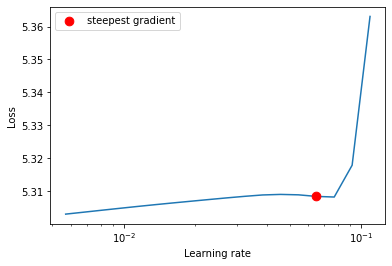

(<matplotlib.axes._subplots.AxesSubplot at 0x7f875fad92e8>,
 0.06482468428208699)

In [ ]:
criterion = cross_entropy_loss() 
optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9,weight_decay = 1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=5, num_iter=50 ,step_mode="exp")
lr_finder.plot()

In [ ]:
Best_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]
Best_lr

0.001

In [ ]:
lr_finder.reset()

In [10]:
from torch.optim.lr_scheduler import OneCycleLR
#model = NewResnet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay = 0.0001,nesterov = True)
criterion = cross_entropy_loss()

EPOCHS =25
scheduler = OneCycleLR(optimizer, max_lr = 0.02, epochs=EPOCHS,
                       steps_per_epoch=len(train_loader), pct_start=0.3,
                       div_factor=10, final_div_factor=10)
       

train_losses = []
test_losses = []
train_acc = []
test_acc = []
print(device)
model = model.to(device)
batch_scheduler = True
l1_factor =0
runmodel(model,device,train_loader,test_loader,optimizer,scheduler,EPOCHS,criterion, train_losses,train_acc,test_losses,test_acc,l1_factor,batch_scheduler)


  0%|          | 0/301 [00:00<?, ?it/s]

cuda
EPOCH: 0


Loss=4.408092021942139 Batch_id=300 Accuracy=4.44: 100%|██████████| 301/301 [05:17<00:00,  1.06s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 2400/33000 (7.27%)

EPOCH: 1


Loss=3.928816318511963 Batch_id=300 Accuracy=11.31: 100%|██████████| 301/301 [05:24<00:00,  1.08s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0163, Accuracy: 3736/33000 (11.32%)

EPOCH: 2


Loss=3.4611151218414307 Batch_id=300 Accuracy=17.41: 100%|██████████| 301/301 [05:30<00:00,  1.10s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0147, Accuracy: 5617/33000 (17.02%)

EPOCH: 3


Loss=3.34393310546875 Batch_id=300 Accuracy=22.15: 100%|██████████| 301/301 [05:32<00:00,  1.11s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0144, Accuracy: 6131/33000 (18.58%)

EPOCH: 4


Loss=3.2184393405914307 Batch_id=300 Accuracy=26.23: 100%|██████████| 301/301 [05:29<00:00,  1.09s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0146, Accuracy: 6171/33000 (18.70%)

EPOCH: 5


Loss=2.891587495803833 Batch_id=300 Accuracy=29.60: 100%|██████████| 301/301 [05:34<00:00,  1.11s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0138, Accuracy: 7073/33000 (21.43%)

EPOCH: 6


Loss=2.928770065307617 Batch_id=300 Accuracy=32.86: 100%|██████████| 301/301 [05:29<00:00,  1.09s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0127, Accuracy: 8788/33000 (26.63%)

EPOCH: 7


Loss=2.668367862701416 Batch_id=300 Accuracy=35.47: 100%|██████████| 301/301 [05:30<00:00,  1.10s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0128, Accuracy: 8673/33000 (26.28%)

EPOCH: 8


Loss=2.5286507606506348 Batch_id=300 Accuracy=37.97: 100%|██████████| 301/301 [05:33<00:00,  1.11s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0127, Accuracy: 9228/33000 (27.96%)

EPOCH: 9


Loss=2.671382188796997 Batch_id=300 Accuracy=40.24: 100%|██████████| 301/301 [05:26<00:00,  1.08s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0115, Accuracy: 10696/33000 (32.41%)

EPOCH: 10


Loss=2.3429601192474365 Batch_id=300 Accuracy=42.22: 100%|██████████| 301/301 [05:31<00:00,  1.10s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0112, Accuracy: 11319/33000 (34.30%)

EPOCH: 11


Loss=2.45536208152771 Batch_id=300 Accuracy=44.12: 100%|██████████| 301/301 [05:31<00:00,  1.10s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0113, Accuracy: 11333/33000 (34.34%)

EPOCH: 12


Loss=2.345527410507202 Batch_id=300 Accuracy=45.93: 100%|██████████| 301/301 [05:29<00:00,  1.09s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0113, Accuracy: 11378/33000 (34.48%)

EPOCH: 13


Loss=2.2032809257507324 Batch_id=300 Accuracy=47.66: 100%|██████████| 301/301 [05:35<00:00,  1.11s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0102, Accuracy: 12704/33000 (38.50%)

EPOCH: 14


Loss=2.0621352195739746 Batch_id=300 Accuracy=49.44: 100%|██████████| 301/301 [05:29<00:00,  1.09s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0100, Accuracy: 13119/33000 (39.75%)

EPOCH: 15


Loss=1.84001886844635 Batch_id=300 Accuracy=51.14: 100%|██████████| 301/301 [05:33<00:00,  1.11s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0106, Accuracy: 12556/33000 (38.05%)

EPOCH: 16


Loss=1.76456880569458 Batch_id=300 Accuracy=52.72: 100%|██████████| 301/301 [05:34<00:00,  1.11s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0099, Accuracy: 13415/33000 (40.65%)

EPOCH: 17


Loss=1.9162472486495972 Batch_id=300 Accuracy=54.37: 100%|██████████| 301/301 [05:35<00:00,  1.11s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0096, Accuracy: 14090/33000 (42.70%)

EPOCH: 18


Loss=1.8820255994796753 Batch_id=300 Accuracy=56.69: 100%|██████████| 301/301 [05:35<00:00,  1.11s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0091, Accuracy: 14601/33000 (44.25%)

EPOCH: 19


Loss=1.6957875490188599 Batch_id=300 Accuracy=58.33: 100%|██████████| 301/301 [05:34<00:00,  1.11s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 15117/33000 (45.81%)

EPOCH: 20


Loss=1.610414981842041 Batch_id=300 Accuracy=60.64: 100%|██████████| 301/301 [05:34<00:00,  1.11s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0086, Accuracy: 15671/33000 (47.49%)

EPOCH: 21


Loss=1.4595569372177124 Batch_id=300 Accuracy=63.04: 100%|██████████| 301/301 [05:34<00:00,  1.11s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0083, Accuracy: 16126/33000 (48.87%)

EPOCH: 22


Loss=1.295263409614563 Batch_id=300 Accuracy=64.77: 100%|██████████| 301/301 [05:34<00:00,  1.11s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0081, Accuracy: 16513/33000 (50.04%)

EPOCH: 23


Loss=1.352266788482666 Batch_id=300 Accuracy=66.60: 100%|██████████| 301/301 [05:35<00:00,  1.11s/it]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 16784/33000 (50.86%)

EPOCH: 24


Loss=1.3363518714904785 Batch_id=300 Accuracy=67.86: 100%|██████████| 301/301 [05:34<00:00,  1.11s/it]



Test set: Average loss: 0.0079, Accuracy: 16819/33000 (50.97%)



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or 

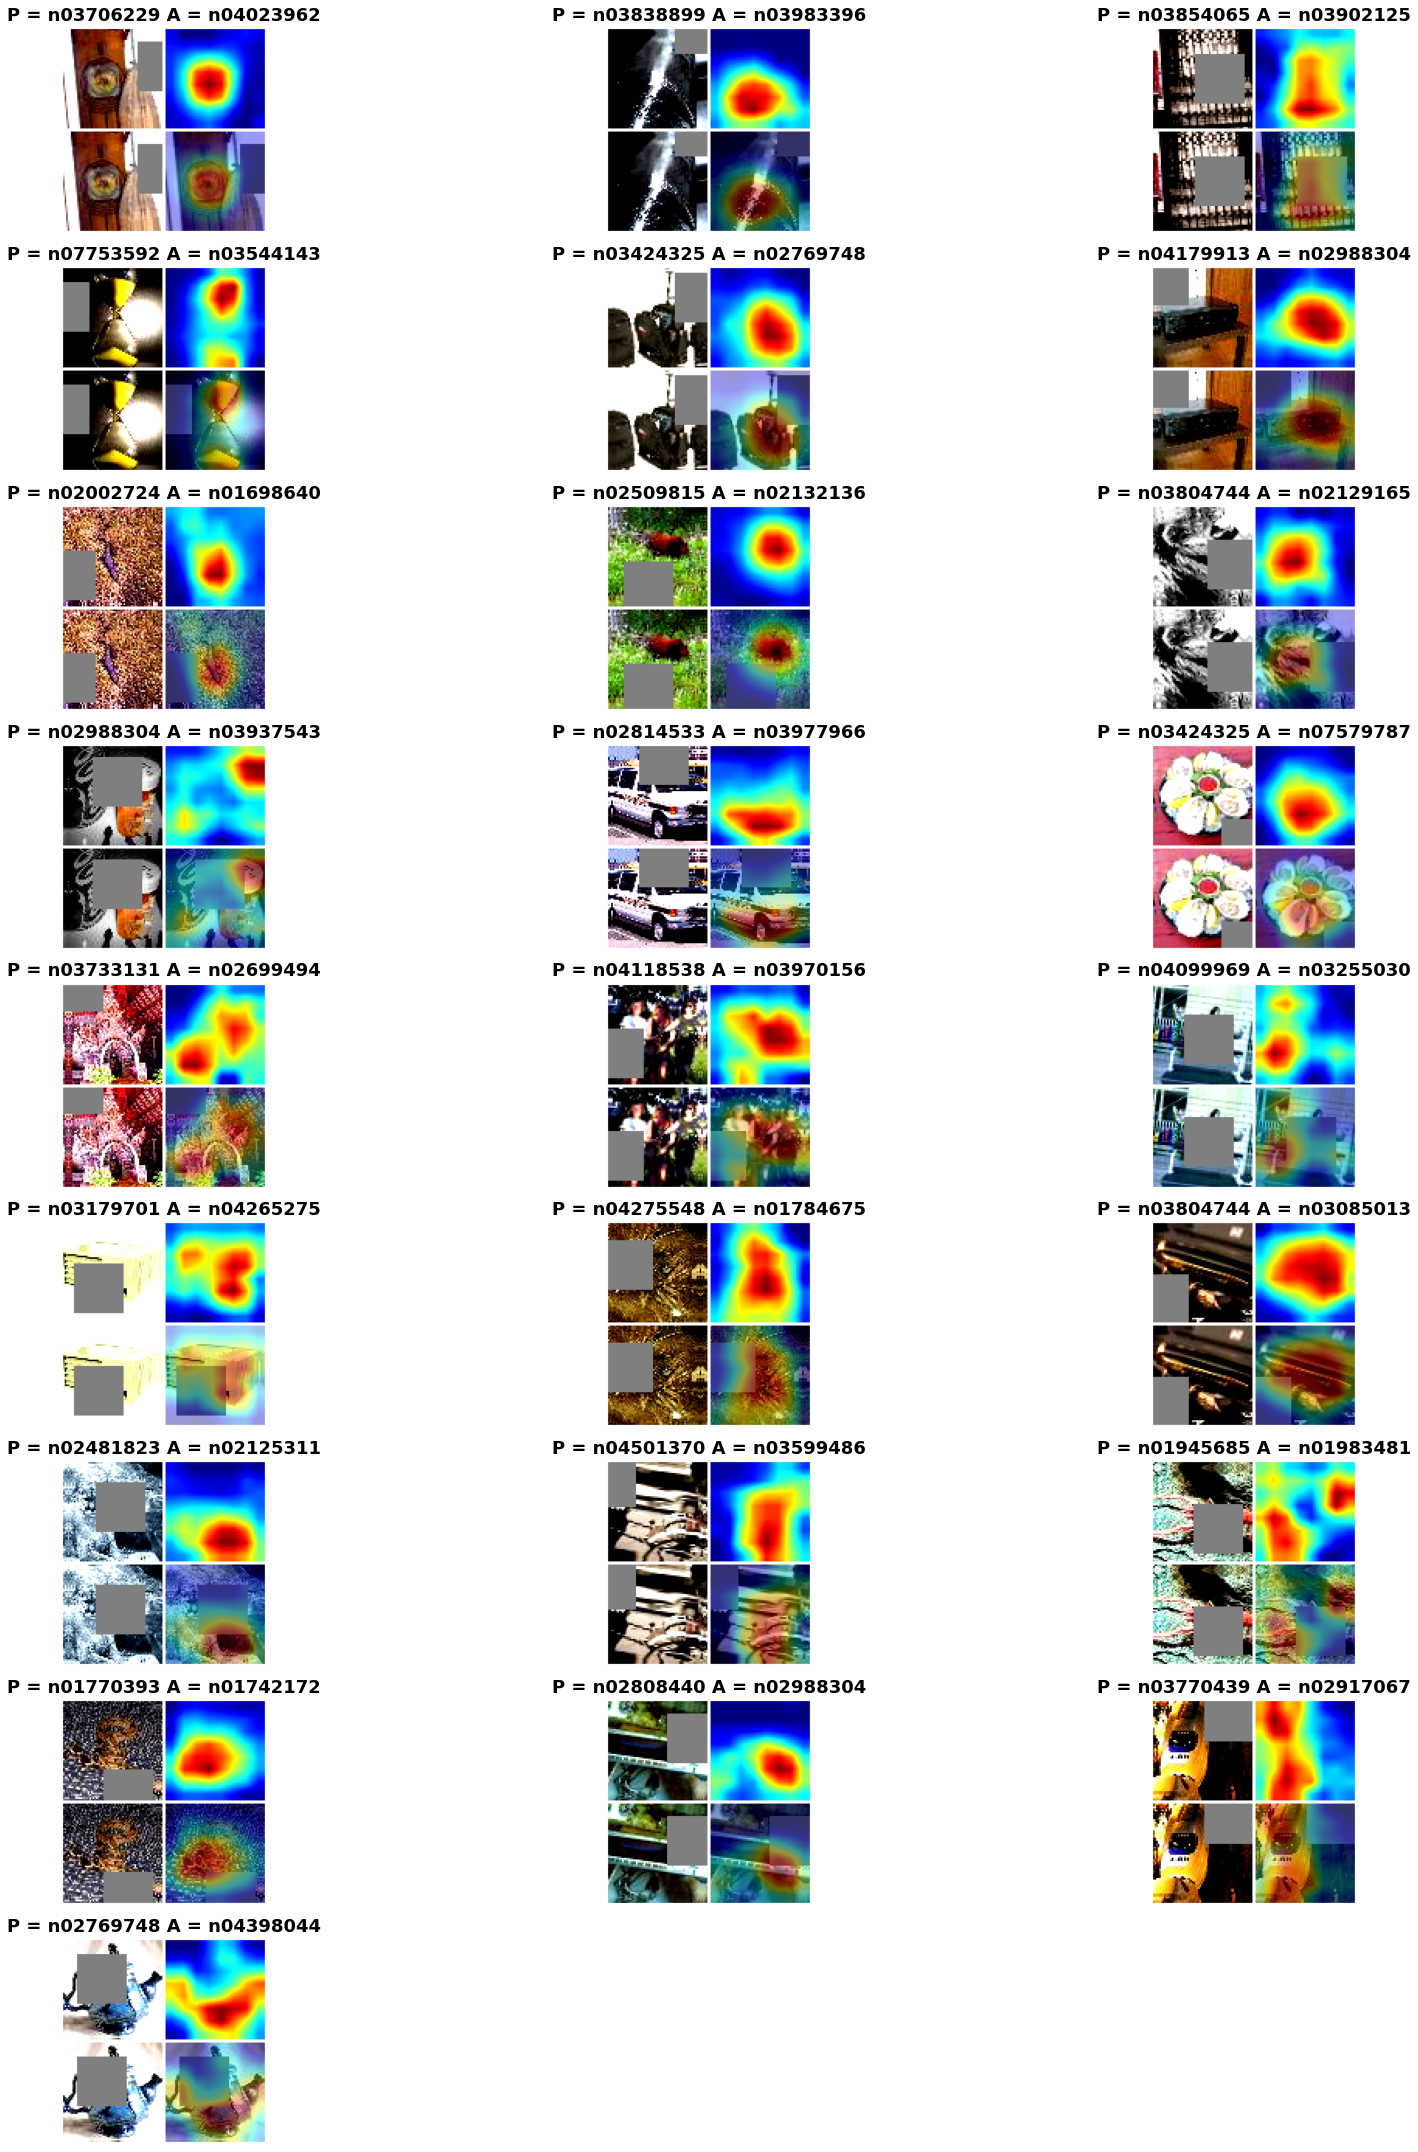

In [11]:
miscalssified_images = show_misclassified_images(model,device,test_loader,classes) # get he misclassfied Images
layers = [model.layer4]  # layers that we want to see in Gradcam.
GradCamView(miscalssified_images,model,classes,layers) # call Gradcam class.

In [12]:
count =0
sum =0
train_batch_acc = []
for i in range(len(train_acc)):
  sum = sum +train_acc[i]
  count = count+1
  if(count == 300):
    train_batch_acc.append(sum/300)
    count =0
    sum =0


In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_metric1(train_acc, test_acc,metric):
    # Initialize a figure
    plt.style.use("dark_background")
    fig = plt.figure(figsize=(11, 9))
    
    # Plot values
    train_acc_plt, = plt.plot(train_acc)
    test_acc_plt, = plt.plot(test_acc)
    

    # Set plot title
    plt.title(f'{metric}')

    # Label axes
    plt.xlabel('Epoch')
    plt.ylabel(metric)

    # Set legend
    location = 'upper' if ((metric == 'Test loss') or (metric == 'Train loss')) else 'lower'
    plt.legend(
        (train_acc_plt, test_acc_plt),
        ('Train Accuracy', 'Test Accuracy'),
        loc=f'{location} right',
        shadow=True,
        prop={'size': 10}
    )


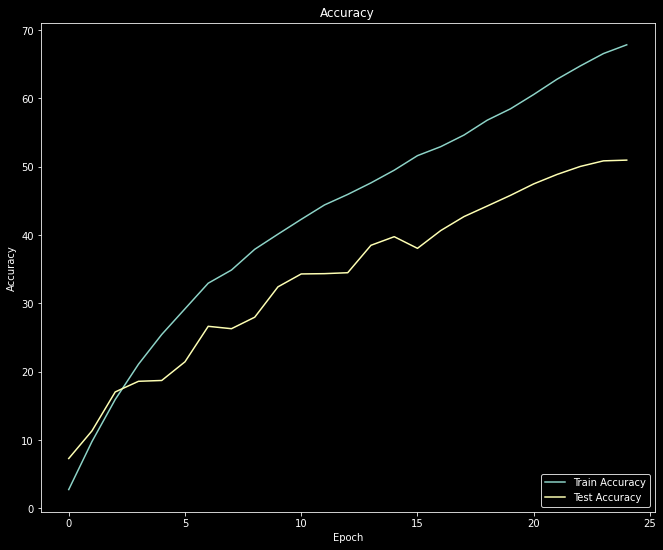

In [14]:
plot_metric1(train_batch_acc, test_acc,metric ='Accuracy')